# Neural Networks
Artificial Neural Networks (ANNs) were first introduced in 1943 by McCulloch (neurophysiologist) and Pitts (mathematician) in their paper *A Logical Calculus of Ideas Immanent in Nervous Activity"*. They proposed a simplified computational model of how biological neurons could work together in animal brains to perform computations using *propositional logic*. In 1957, Rosenblatt invented the Perceptron, which is considered to be one of the simplest linear ANN architectures. Rosenblatt's Perceptron is based on a slightly different artificial neuron, called a *threshold logic unit* (TLU) or *linear threshold unit* (LTU). Interest in ANNs faded in the 1960s. In the early 1980s, new architectures and better training techniques were developed and there was renewed interest, but slow progress, with NNs. In the 1990s other ML algorithms were invented (like SVM) that had better results and stronger theoretical foundations than ANNs, so interest in NNs faded again. 

Today's interest in NNs will likely continue for the following reasons: 
<ol>
    <li> Today we have massive amounts of data for training NNs and ANNs often outperform other ML techniques on large and complex problems.  </li>
    <li> Increases in computing power since the 90s makes it possible to train large NNs in a reasonable amount of time. Moore's law, the development of powerful GPUs for the gaming industry, and cloud platforms are credited with making NNs accessible to everyone.  </li>
    <li> Initial training algorithms from the 90s, though only slightly modified, are much more powerful now. </li>
    <li> When first developed, there were many theoretical concerns about NN limitations. However, now we know that these potential problems are rarely seen in practice. </li>
    <li> NNs are incredibly popular today which means more research funding is available for their study. Products based on NNs often make the news, which increases attention, which increases funding, which results in more progress. </li>   
</ol>

## Backpropagation
In 1986, Rumelhart, Hinton, and Williams published the backpropagation training algorithm for NNs. Hinton (along with Bengio and LeCun) received the 2018 ACM Turing Award for their foundational work in developing NNs. 

Backprop is essentially gradient descent using an efficient technique to compute the gradients automatically (automatic differentiation) in a forward and backward pass through the NN. Backprop computes the gradient of the network's error with respect to every model parameter, meaning it determines how each weight and bias should be altered in order to reduce the error. Once backprop has these gradients, it performs a regular GD step. The whole process is repeated until the network converges to the solution. Another way to think of it is: for each training instance, the backprop algorithm makes a prediction (forward pass) and measures the error, then goes back through each layer in reverse to measure the error contribution from each connection (reverse pass), and finally updates the connection weights to reduce the error (GD step). 

**Note:** It's important to intialize all hidden layer weights randomly or training will fail. If you initialize all weights and biases to 0, then all neurons in a given layer are perfectly identical and backprop will alter them in the same way, so they will remain identical. 


## Multilayer Perceptron (MLP)
A basic MLP has one *input layer*, one or more *hidden layers* of TLUs, and one final *output layer* of TLUs. Every layer (except the output layer) includes a *bias* neuron and is fully connected to the next layer. Because the signal only moves in one direction (from input layer to output layer) this architecture is an example of a *feedforward NN* (FNN). 

MLPs can be used for regression tasks. If you want to predict a single value, you just need a single output neuron. Its output will be the predicted value. If you want to predict multiple values at once (multivariate regression), you will need one output neuron per output dimension. 

You can also use MLPs for classification tasks. For a binary classification, you just need a single output neuron using the logistic activation function. Its output will be between 0 and 1, which can be interpreted as the estimated probability of the positive class. One minus that number would be the estimated probability of the negative class. You can also handle multilabel and multiclass classification tasks. For example, with the Digits dataset, to predict numbers 0..9, we would need one output neuron per class, with the softmax activation function over the whole output layer. 

# Building an Image Classifier Using the Sequential API

## Visualize the Fashion MNIST Dataset 
Fashion MNIST has 60,000 grayscale images of 28x28 pixels each. There are 10 classes. A simple linear model can reach about 83% accuracy on this dataset. 

In [11]:
# Imports
# You will probably need to install Tensorflow & Keras
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

# For figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Stabilize across runs
np.random.seed(42)

In [2]:
# Load Fashion MNIST Dataset
fashion_mnist = keras.datasets.fashion_mnist

# Recover training & testing splits
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Training set contains 60,000 grayscale images, each 28x28 pixels
# Each pixel intensity is represented as a byte (0 to 255)
X_train_full.shape

In [3]:
# Split training set into a validation set & smaller training set
# Scale pixel intensities down to 0..1 range & convert them to floats by dividing by 255.
# (Scaling the input features because we're using Gradient Descent to train the NN)
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

# Validation set contains 5,000 images
# Test set contains 10,000 images
# X_valid.shape
# X_test.shape

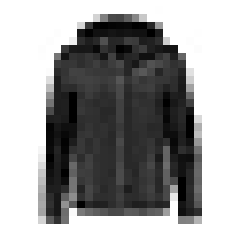

In [7]:
# Plot an image using Matplotlib's imshow() function with a 'binary' color map
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [8]:
# Labels are class IDs (represented as uint8) from 0..9
y_train

In [9]:
# Corresponding class names 
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

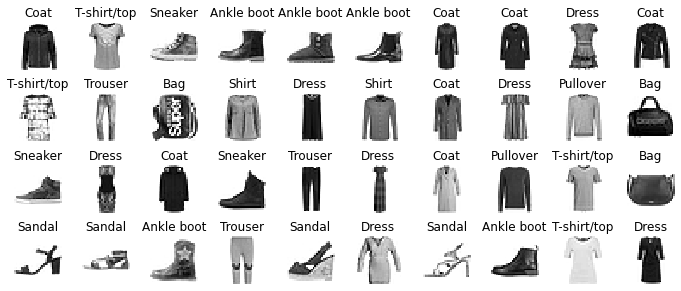

In [10]:
# Visualize dataset sample
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Create the Model Using the Sequential API

We'll create a classification MLP with 2 hidden layers. We're using a Sequential model which is good for a basic stack of layers, where each layer only has one input tensor and one output tensor. 
Then we'll add layers in order: 
<ol>
    <li> Input layer: we'll use the Keras Flatten layer class which flattens the input. You have to specify the dimensions of your input. </li>
    <li> Hidden layer 1: we'll use the Keras Dense layer class which is a densely-connected layer. We'll specify 300 nodes/units and the RELU activation function. </li>
    <li> Hidden layer 2: another Dense layer with 100 nodes and RELU activation function. </li>
    <li> Output layer: a Dense layer with 10 nodes and the Softmax activation function. The 10 nodes are 1 node per class (each article of clothing). We'll use Softmax for classification (as discussed in class). </li> 
</ol>

In [11]:
# Set up our first NN
# Sequential Model: single stack of layers connected sequentially 
model = keras.models.Sequential()

# Input layer dimensions: 28 x 28
# Flattens the input image into a 1D array
# Layer has no parameters; just performs preprocessing
# Alternate layer: keras.layers.InputLayer(input_shape=[28,28])
model.add(keras.layers.Flatten(input_shape=[28, 28]))

# Hidden layer with 300 neurons & RELU activation function
# Each Dense layer manages its own weight matrix W which contains all 
#     connection weights between neurons & their inputs
# Also manages a vector of bias terms (1 per neuron)
model.add(keras.layers.Dense(300, activation="relu"))

# Hidden layer with 100 nodes & RELU activation function
model.add(keras.layers.Dense(100, activation="relu"))

# Ouput layer with 10 nodes (1 node per clothing class) & Softmax activation
model.add(keras.layers.Dense(10, activation="softmax"))

In [12]:
# Clear
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
# More common way to write the above NN
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

**Note:** Dense layers have A LOT of parameters! 
Hidden Layer 1 has 784 x 300 connection weights + 300 bias terms = 235,500 parameters.
This large number of parameters gives the model flexibility to fit the training data, but risks overfitting if there isn't enough training data. 

In [14]:
# Display model's layers
# Names are automatically generated unless set when creating the layer 
# Output shape: None means batch size can be anything
# Number of Parameters
model.summary()

In [15]:
# Name the first hidden layer
# You can fetch layers by index or name
hidden1 = model.layers[1]
hidden1.name

In [16]:
# Weights & biases for the layer
# There's also a set_weights() method
weights, biases = hidden1.get_weights()

In [17]:
# Print weights
weights
# weights.shape
# biases
# biases.shape

### Compile the NN Model
After creating a NN, use the **compile()** method to specify the loss function and optimizer. We'll use Sparse Categorical Cross-Entropy as the loss function because we have sparse labels and our 10 output classes are mutually exclusive. For optimization we'll use SGD (stochastic gradient descent). And we'll measure performance with the accuracy metric. 

In [18]:
# Compile the model
# Using: Sparse categorical crossentropy loss function (good for this classification task)
# Stochastic Gradient Descent for optimization
# Check performance with accuracy 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

### Train & Evaluate the Model
Pass the training data, training labels, specify the number of epochs to run, and a validation set. It's common to save the fit results in a 'history' variable because fit() returns a *History* object. *History* objects contain the training parameters (history.params), list of epochs (history.epoch), and a dictionary (history.history) containing the loss and extra metrics measured at the end of each epoch on the training and validation (if available) sets. You can use this dictionary to create a *pandas DataFrame* and call its plot( ) method to visualize the NN's learning curves. 

In [19]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

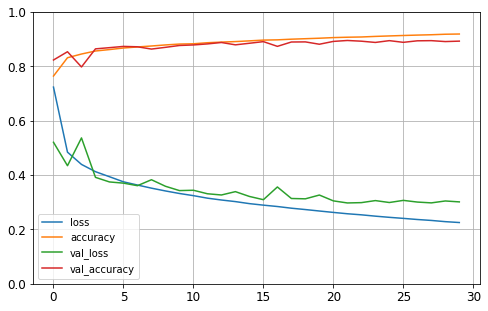

In [20]:
# Visualize learning curves of NN's History
# For best results, you'd need to shift the training curve half an epoch to the left
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Analysis
The training and validation accuracy steadily increase during training, while the training and validation loss decrease. This is good! The validation curves are close to the training curves, so there isn't much overfitting. The training set performances beats the validation performance, which usually happens if you train for long enough. The model hasn't converged yet (if indicated by the validation loss still decreasing), so you would normally continue training from here. You can just call the **fit( )** method again, because Keras will continue training from where it left off. 

### Using the Model to Make Predictions
You can use the **predict( )** method to make predictions on new instances. 

In [21]:
# Checking with the first 3 instances 
# For each instance, the model estimates 1 probability per class, from class 0..9. 
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

In [22]:
# If you only want the class with the highest estimated probability
# predict_classes( ) has been deprecated
# Use np.argmax on predict
y_pred = np.argmax(model.predict(X_new), axis=-1)
#y_pred
np.array(class_names)[y_pred]
y_new = y_test[:3]
y_new

# RNN
RNNs are typically used in tasks that try to "predict the future". For example, RNNs can analyze time series data like stock prices and predict when to buy or sell. In autonomous driving systems, RNNs can anticipate car trajectories and help avoid accidents. In general, they are used for sequences of arbitrary lengths, instead of fixed-size input like many other NNs. This is what makes them super useful for NLP tasks. 

RNNs look a lot like FFNs except they also have connections pointing backwards, meaning a neuron (layer) can send its output back to itself. At each time step, a recurrent neuron receives input $x_t$ as well as its own output from the previous time step $y_{t-1}$ (or 0 if it's the first time step because there is no previous output at the start). If you represent each time step against a sequential time axis, this is called *unrolling the network through time*. Since the output or a recurrent neuron/layer at *t* is a function of all the input from previous time steps, RNNs are said to have memory. 

RNNs use *backprop through time* and have the 2 following challenges:
<ol>
    <li> Unstable gradients that have to be handled with techniques like recurrent dropout and recurrent layer normalization.  </li>
    <li> Limited short-term memory, which can be extended using LSTM or GRU cells (as discussed in class). </li>
</ol>

## Input & Output Sequences
**Sequence-to-sequence Network:** Takes a sequence of inputs and produces a sequence of outputs. Example: predicting time series like stock prices. 
**Sequence-to-vector Network:** Takes a sequence of inputs and ignores all outputs except for the last one. Example: input a movie review and output a sentiment score from -1 (hate it) to +1 (love it).  
**Vector-to-sequence Network:** Input the same vector over and over again at each time step and network outputs a sequence. Example: input an image and output a caption for that image. 
**Encoder-Decoder:** You can have a sequence-to-vector network (encoder) followed by a vector-to-sequence network (decoder). Example: translate a sentence from one language to another. 

# Building an RNN
First, let's create a time series dataset and build the simplest RNN. It has one layer with one neuron. We don't need to specify the length of the input sequence because RNNs can process any number of time steps. By default, the *SimpleRNN* uses the hyperbolic tangent activation function. 

In [23]:
# Generate time series dataset
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

np.random.seed(42)

# Create training, testing, & validation sets
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [24]:
# Sequential Model: RNN
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

# Adam optimizer 
optimizer = keras.optimizers.Adam(lr=0.005)

# MSE loss function
model.compile(loss="mse", optimizer=optimizer)

# Run for 20 epochs
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

In [25]:
# This SimpleRNN will beat a naive approach but not a simple linear model
# QUESTION 1: why do you think this is the case? (Space to answer Qs at bottom of code)
model.evaluate(X_valid, y_valid)

It's more common to stack multiple layers of cells to build a deep RNN. With Keras we just need to stack recurrent layers. 

In [26]:
# Deep RNN using 3 SimpleRNN layers
# You could add any other type of recurrent layer like LSTM or GRU
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20, return_sequences = True),
    # QUESTION 2: Why do we use 'return_sequences = True' in the previous layers, but not the output layer? 
    keras.layers.SimpleRNN(1)
])

In [27]:
# Compile the Deep RNN above
# Use MSE for the loss function & the Adam optimizer
model.compile(loss="mse", optimizer="adam")

In [28]:
# Fit the Deep RNN
# Run 20 epochs (or less depending on your computer's speed)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Let's create a more efficient version of the Deep RNN above. The last layer above is not ideal because it has a single unit (for forecasting a univariate time series), so this means we have a single output value per time step. But this limits the hidden state to just a single number, which isn't that useful. If we switch to a *Dense* final layer, we can fix this problem, the NN will run faster, and we can also use any output activation function. 

In [29]:
# Switch to a Dense output layer
# It should converge faster and have similar or better performance
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    # QUESTION 3: Why do we remove 'return_sequences = True' from this 2nd layer? 
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Let's predict the future! There's different ways to do this, like predicting one value at a time or predicting the next 10 values all at once. The code below will use our model above to predict the next value, and then add that value into the input (acting like the prediction has actually occurred), and then use the model to predict the next value, and so on. This type of approach is only good for forecasting a few time steps ahead.

In [32]:
np.random.seed(43) # not 42, as it would give the first series in the training set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]
Y_pred

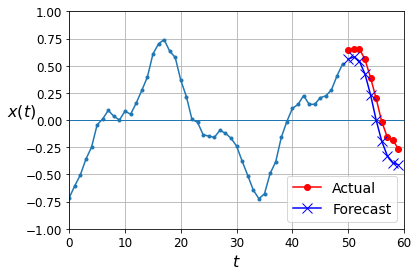

In [34]:
# Visualize the predictions
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    
    
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Using a Character-RNN to Generate Shakespearean Text
In a 2015 blog "The Unreasonable Effectiveness of Recurrent Neural Networks", Andrej Karpathy showed how to train an RNN to predict the next character in a sentence. This Char-RNN can be used to generate novel text, one character at a time. 

## Create Training Dataset
Download Shakespeare's work from Karpathy's Char-RNN project. 

In [12]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

Next, we have to encode every character as an integer. We'll use Keras' *Tokenizer* class (another option is to create a custom preprocessing layer). This will find all the characters used in the text and map each character to a different character ID, from 1 to the number of unique characters. 0 is reserved for masking. 

In [13]:
# Tokenizer's default is word-level encoding, so need to set char_level
# Tokenizer also converts to lowercase by default (set lower=False to change it)
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [14]:
tokenizer.texts_to_sequences(["First"])

In [15]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

In [16]:
# Number of unique characters
max_id = len(tokenizer.word_index) 
# Total number of characters
dataset_size = tokenizer.document_count 

In [17]:
# Encode the full text
# Subtract 1 to get IDs from 0..38 (instead of 1..39)
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

Next, we need to split the dataset into a training, validation, and test set. But because this is sequential data, we can't just shuffle all the characters in the text. It's important to avoid any overlap between the 3 sets. The typical approach is to take the first 90% of data for training, the next 5% for validation, and the final 5% for testing. For text, it's usually a good idea to leave space between the sets to avoid paragraphs that could overlap any 2 sets. 

In [22]:
# Take the first 90% of data for training
# This will be a single sequence of > 1 million characters
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [23]:
# Use Dataset's window( ) method to convert long character sequence
#     into many smaller windows of text
# Default is to create nonoverlapping windows
# Each window is represented as a Dataset, so it's a nested dataset (~list of lists)
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

In [24]:
# Cannot use nested dataset directly for training
# Model expects tensors (not datasets) as input
# flat_map( ): converts nested dataset into a flat dataset
# Returns: dataset with consecutive windows of 101 characters each
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [25]:
# Shuffle the windows (because Gradient Descent works best when training instances are IID)
# Batch them & separate the input (first 100 chars) from the target (last char)
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [26]:
# Categorical input features should be encoded, usually as a 1-hot vector or embedding
# Using 1-hot here because there's only 39 distinct characters
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [27]:
# Prefetching
dataset = dataset.prefetch(1)

## Build & Train the Char-RNN Model
To predict the next character based on the previous 100 characters, we can use an RNN with 2 GRU layers. Each layer needs 128 neurons/nodes/units each and 20% dropout (to overcome the unstable gradients problem) on both the input and hidden states. These hyperparameters can be fine-tuned through experimentation. In order to use dropout in the hidden layers, you would have to set *recurrent_dropout = 0.2*. However, the GRU class would need the GPU to run recurrent_dropout quickly enough to complete the assignment. 

Our output layer will be a *Time-Distributed Dense* layer with 39 units because there are 39 distinct characters in our text and we want to output a probability for each possible character at each time step. We'll use the softmax activation function over the output of the Dense layer to make the output probabilities sum to 1 at each time step. 

In [28]:
# Create a Sequential model
# Layer 1 (Input): GRU, 128 nodes, return_sequences = True, 
#          input_shape is None & the number of unique characters, 
#          droput is 20% (0.2) 
# Layer 2: GRU, 128 nodes, return sequences, 20% dropout
# Layer 3 (Output): TimeDistributed Dense layer with 39 nodes & softmax activation function
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id], dropout=0.2),
    keras.layers.GRU(128, return_sequences=True, dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
])


In [29]:
# Compile the model with Sparse Categorical Crossentropy loss function & the Adam optimizer
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")


In [ ]:
# Fit the model 
# If you can use a GPU, 10 epochs should take about 1-2 hours
# Without a GPU, this could take up to 24 hours
# Try running 1 epoch first to see how long it takes & then
#     increase the number of epochs (if possible)
# 1 epoch took me about 70 minutes to run
history = model.fit(dataset, steps_per_epoch=train_size // batch_size, epochs=1)

## Using the Char-RNN Model
First preprocess the test text. Then use the model to predict the next letter in some text. If you were able to run several epochs, the model should get this prediction (the letter 'u') correct. If you could only run 1 epoch, it will likely be wrong. 

In [ ]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

X_new = preprocess(["How are yo"])
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

In [ ]:
# Helper functions for generating text
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [ ]:
# Test generating text
print(complete_text("t", temperature=0.2))
print(complete_text("t", temperature=1))
print(complete_text("t", temperature=2))

In [ ]:
# QUESTION 1: why do you think this is the case? (
# QUESTION 2: Why do we use 'return_sequences = True' in the previous layers, but not the output layer? 
# QUESTION 3: Why do we remove 'return_sequences = True' from this 2nd layer? 


To generate better text, you could add more GRU layers, more neurons per layer, train for more epochs, or add regularization (e.g., recurrent_dropout = 0.3). You could also increase the window size, but that would make training harder and LSTM/GRU can't handle very long sequences. 

I enjoyed teaching you all this semester. I hope you have a great summer! 